In [210]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import minimize, fmin_bfgs
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

# Lab 08
### Emil Magerramov

## Assignment 1

The task is to estimate mean and median statistics for the target variables $y_i$ using Bootstrap procedure.  
Then, linear models for the target variables should be created and coefficients of these models (including the intercept) should be estimated using Bootstrap.

### Load the datasets

In [93]:
# The datasets are swapped for some reason
dataset2 = pd.read_csv("./ds-boot-1.csv", sep='\t')
dataset1 = pd.read_csv("./ds-boot-2.csv", sep='\t')

### Check the first dataset

In [213]:
dataset1.head(3)

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,...,p19,p20,p21,p22,p23,p24,p25,p26,p27,p28
0,6.48148,3.0,5.0,7.75000,0.0,7.16667,8.16667,9.66667,6.16667,9.0,...,0.0,3.0,1.66667,1.33333,0.0,1.66667,3.16667,0.0,0.00000,0.0
1,5.74074,4.0,8.0,7.33333,8.0,8.83333,9.75000,9.66667,9.00000,10.0,...,7.0,3.5,8.46667,7.33333,7.0,2.50000,5.50000,5.0,8.66667,8.0
2,7.59259,7.0,8.0,7.66667,8.0,9.66667,9.50000,6.16667,9.66667,6.5,...,8.0,10.0,8.50000,10.00000,9.0,3.50000,3.50000,9.0,6.50000,7.0


### Split the 1st dataset into X and y

In [95]:
target_names = ['y' + str(i) for i in range(1, 6)]
targets = dataset1[target_names]
dataset1.drop(target_names, axis=1, inplace=True)
dataset1.drop('id', axis=1, inplace=True)

In [34]:
def bootstrap_estimate(func, data, B=1000):
    """
    Args:
        func - statistic to estimate
        data - vector of values
        B - number of bootstrap samples
    
    Returns:
        estimate, std - estimation for the func
    """
    samples = np.random.choice(data, size=(B, len(data)))
    statistics = np.apply_along_axis(func, axis=1, arr=samples)
    b_mean = np.mean(statistics)
    b_std = np.std(statistics)
    return b_mean, b_std

### Estimate the targets $y_i$ using Bootstrap

In [35]:
for target_name in target_names:
    target = targets[target_name]
    print("Evaluating", target_name)
    
    print("Mean:")
    mean_b_mean, mean_b_std = bootstrap_estimate(np.mean, target)
    print("({} +- 1.96 * {}) for 95% confidence".format(mean_b_mean, mean_b_std))
    print()
    print("Median:")
    median_b_mean, median_b_std = bootstrap_estimate(np.median, target)
    print("({} +- 1.96 * {}) for 95% confidence".format(median_b_mean, median_b_std))
    print(); print()

Evaluating y1
Mean:
(4.025525 +- 1.96 * 0.46388209641567324) for 95% confidence

Median:
(4.00625 +- 1.96 * 0.573714595857557) for 95% confidence


Evaluating y2
Mean:
(5.49970625 +- 1.96 * 0.52201355911359) for 95% confidence

Median:
(6.172875 +- 1.96 * 0.7124814800224635) for 95% confidence


Evaluating y3
Mean:
(7.33241775 +- 1.96 * 0.45930786807155555) for 95% confidence

Median:
(8.309085 +- 1.96 * 0.2750371570806391) for 95% confidence


Evaluating y4
Mean:
(1.5212154999999998 +- 1.96 * 0.11332830983364219) for 95% confidence

Median:
(1.85524 +- 1.96 * 0.13428623309930174) for 95% confidence


Evaluating y5
Mean:
(5.607217 +- 1.96 * 0.4242976871089448) for 95% confidence

Median:
(6.195824999999999 +- 1.96 * 0.4247392074850167) for 95% confidence




In [100]:
def bootstrap_estimate_regressor(regressor_class, X, y, B=1000):
    """
    Args:
        regressor - class of the regressor (example: LinearRegression)
        X - data, np.array
        y - target, np.array
        B - number of bootstrap samples
        
    Returns:
        means, stds: tuple of lists of values
    """
    resample_indices = np.random.choice(list(range(X.shape[0])), size=(B, X.shape[0]))
    coefficients = np.ndarray((B, X.shape[1] + 1)) # + 1 for the intercept
    
    for i in range(B):
        X_resample = X.iloc[resample_indices[i], :]
        y_resample = y[resample_indices[i]]
        regressor = regressor_class()
        regressor.fit(X_resample, y_resample)
        coefficients[i] = np.concatenate((regressor.coef_, [regressor.intercept_]))
        
    coef_means, coef_stds = [], []
    for i in range(coefficients.shape[1]):
        cur_coef = coefficients[:, i]
        coef_means.append(np.mean(cur_coef))
        coef_stds.append(np.std(cur_coef))
    
    return coef_means, coef_stds

### Create a linear model for each $y_i$

Create a LinearRegression model for each $y_i$ and evaluate it using Mean Squared Error.

In [211]:
for target_name in target_names:
    target = targets[target_name]
    X_train, X_test, y_train, y_test = train_test_split(dataset1, target, test_size=0.2)
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    print("MSE for", target_name, "is {}".format(mean_squared_error(y_pred, y_test)))
    print()

MSE for y1 is 77.88111176274357

MSE for y2 is 43.4188974167444

MSE for y3 is 3.6396430922531744

MSE for y4 is 14.487679595848666

MSE for y5 is 4.757983590806139



### Now estimate confidence intervals for the coeffifients of a linear model

For the second part of the first assignment the resampling procedure is the following:  
 * Sample train data from X and y with repetitions B times.  
 * Then, train a linear model on these data and save the coeffients of the model.  
 * Finally, calculate the mean and the standard deviation for each coeffifient to estimate the confidence interval.

In [212]:
for target_name in target_names:
    target = targets[target_name]
    print("Evaluating", target_name, "confidence intervals for coeffs for 95% confidence")
    
    coef_means, coef_stds = bootstrap_estimate_regressor(LinearRegression, dataset1, target)
    for i in range(len(coef_means)):
        current_coef_name = "coefficient_" + str(i)
        if i == len(coef_means) - 1:
            current_coef_name = "the intercept"
        print("Estimating", current_coef_name)
        print("({} +- 1.96 * {})".format(coef_means[i], coef_stds[i]))
    print()

Evaluating y1 confidence intervals for coeffs for 95% confidence
Estimating coefficient_0
(0.3052473918532328 +- 1.96 * 0.2459362485313749)
Estimating coefficient_1
(-0.016330110599094335 +- 1.96 * 0.24739534023004342)
Estimating coefficient_2
(-0.08665757880476911 +- 1.96 * 0.32958021074123506)
Estimating coefficient_3
(0.5928848760191404 +- 1.96 * 0.3360349365294616)
Estimating coefficient_4
(-0.25621866702969215 +- 1.96 * 0.3142084759283443)
Estimating coefficient_5
(0.22120323093850972 +- 1.96 * 0.4324485246556507)
Estimating coefficient_6
(-0.37903163384217897 +- 1.96 * 0.40331838047058954)
Estimating coefficient_7
(-0.08635390600581937 +- 1.96 * 0.3077645649043386)
Estimating coefficient_8
(-0.044652940855385834 +- 1.96 * 0.32766974253338427)
Estimating coefficient_9
(-0.20750107228094405 +- 1.96 * 0.30756256587419756)
Estimating coefficient_10
(0.3783408871328197 +- 1.96 * 0.3874257314125129)
Estimating coefficient_11
(0.05627876378175603 +- 1.96 * 0.3733778257325087)
Estimating

Estimating coefficient_27
(-0.0006467801122101742 +- 1.96 * 0.031162015220312374)
Estimating the intercept
(0.0017643177366053469 +- 1.96 * 0.04828330655329393)

Evaluating y5 confidence intervals for coeffs for 95% confidence
Estimating coefficient_0
(0.09663841059101225 +- 1.96 * 0.15981984763337023)
Estimating coefficient_1
(0.03499265201869525 +- 1.96 * 0.14877430039477219)
Estimating coefficient_2
(-0.03233122744435318 +- 1.96 * 0.20912687306104377)
Estimating coefficient_3
(0.3134966158989402 +- 1.96 * 0.19650934877460513)
Estimating coefficient_4
(-0.04308868686595181 +- 1.96 * 0.1699256546908766)
Estimating coefficient_5
(0.256824407168735 +- 1.96 * 0.2810546317922285)
Estimating coefficient_6
(0.025008048938897312 +- 1.96 * 0.20217867263225608)
Estimating coefficient_7
(-0.08509437382045641 +- 1.96 * 0.18358863542206175)
Estimating coefficient_8
(-0.006785705100062131 +- 1.96 * 0.23968477189752316)
Estimating coefficient_9
(-0.058725180653944616 +- 1.96 * 0.20505820031854122)


## Assignment 2

The task is to determine the best model for the mean number of bugs as a function of time.  
Then, the confidence intervals for each of the model's parameters should be estimated using Bootstrap.

### Check the 2nd dataset

In [201]:
dataset2.head(3)

,day,bugsPerDay,cummBugs
0,1,0,0
1,2,1,1
2,3,0,1


In [199]:
def ros(t, a=1, b=1):
    """
    S-shaped model.
    Accepts t as a timepoint and a, b as model parameters.
    Returns the predicted number of bugs given timepoint.
    """
    return a*(1 - (1 + b*t)*np.exp(-b*t))

Since the data is a time series, the proposed approach to do the sampling is the following:  
 * Set random 10% of data from the `bugsPerDay` column to 0. Then, recalculate the cumulative sum.  
 * The sampling procedure is being repeated B times. For each sample, the least squares optimization is used to determine the best model given the data.  
 * Then, the mean and the standard deviation are calculated to estimate the confidence interval for each of the model's parameters.  
 * Finally, the optimization procedure is executed on the whole dataset in order to do the comparison.

In [195]:
def func_to_min(values):
    """
    Least squares optimization problem 
    to determine the best model given data.
    """
    a, b = values
    return np.sum(np.power(np.array([ros(x, a, b) for x in np.arange(len(current_cumsum))]) - current_cumsum, 2))

B = 1000
results_a, results_b = [], []
throw_away_inds_len = int(0.1 * len(dataset2['day']))
for i in tqdm(range(B)):
    current_bugs = dataset2['bugsPerDay'].copy()
    
    # randomly set some of the bugs to 0
    throw_away_inds = np.random.choice(np.arange(len(current_bugs)), size=throw_away_inds_len)
    current_bugs[throw_away_inds] = 0
    current_cumsum = np.cumsum(current_bugs)
    
    # [5000., 0.001] is a starting point for the parameters
    result = minimize(func_to_min, [5000., 0.001], tol=1e-25)
    a, b = result.x
    
    results_a.append(a)
    results_b.append(b)
    
print("a: ({} +- 1.96 * {})".format(np.mean(results_a), np.std(results_a)))
print("b: ({} +- 1.96 * {})".format(np.mean(results_b), np.std(results_b)))

/usr/local/lib/python3.6/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/usr/local/lib/python3.6/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/usr/local/lib/python3.6/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/usr/local/lib/python3.6/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/usr/local/lib/python3.6/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))



a: (18709.62167630103 +- 1.96 * 144827.36988481347)
b: (0.0018502726499009373 +- 1.96 * 0.00015379929476585236)


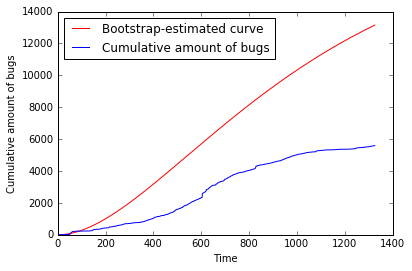

In [205]:
bugs = dataset2['cummBugs']
ros_bugs = [ros(t, np.mean(results_a), np.mean(results_b)) for t in range(len(bugs))]
plt.plot(ros_bugs, color='r', label='Bootstrap-estimated curve')
plt.plot(bugs, label='Cumulative amount of bugs')
plt.xlabel("Time")
plt.ylabel("Cumulative amount of bugs")
plt.legend(loc='upper left');

The bootstrap-estimated model pessimistically overestimated the cumulative amount of bugs over time.

### Optimizing for the whole dataset

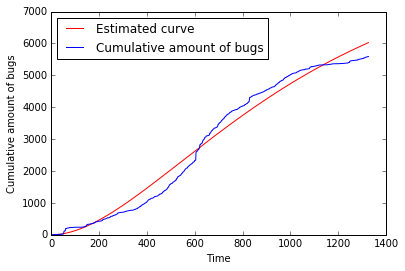

In [206]:
current_cumsum = bugs
result = minimize(func_to_min, [5000., 0.001], tol=1e-25)
a, b = result.x
ros_bugs = [ros(t, a, b) for t in range(len(bugs))]
plt.plot(ros_bugs, color='r', label='Estimated curve')
plt.plot(bugs, label='Cumulative amount of bugs')
plt.xlabel("Time")
plt.ylabel("Cumulative amount of bugs")
plt.legend(loc='upper left');

The model optimized on the whole dataset fitted the data pretty good.